# Telco Customer Churn

## Disclaimer:
- This notebook is not formatted for presentation yet; I am using this to answer question that I have of the data at a specific point in time. 

# import libraries 

In [4]:
#standard library imports 
import os 

#related third party imports 
import pandas as pd 
import numpy as np
import seaborn as sns
import xgboost as xgb 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split 
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV #cross validation
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
#from sklearn.metrics import plot_confusion_matrix

#local application/library specific imports 
import src.dispatcher as dispatcher
import src.dataset as dataset

In [10]:
numerical_features = src.dispatcher.features['numerical_features']

# Takeaways 

Target feature:
- unbalanced target variable (73:27)but not enought to have to to imput data

# Steps for Exploration 

- Feature engineering (1)
- univariate exploration 
- bivariate exploration 
- outlier treatment 
- variable transformation
- variable creation 
- Feture engineering (2)

## Importing Data 

In [5]:
df = pd.read_csv('data/telco-customer-churn-clean-folds.csv')

In [6]:
df.head(5)

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn,k_fold
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,1
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,1
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,1
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,2


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             7043 non-null   object 
 1   senior_citizen     7043 non-null   int64  
 2   partner            7043 non-null   object 
 3   dependents         7043 non-null   object 
 4   tenure             7043 non-null   int64  
 5   phone_service      7043 non-null   object 
 6   multiple_lines     7043 non-null   object 
 7   internet_service   7043 non-null   object 
 8   online_security    7043 non-null   object 
 9   online_backup      7043 non-null   object 
 10  device_protection  7043 non-null   object 
 11  tech_support       7043 non-null   object 
 12  streaming_tv       7043 non-null   object 
 13  streaming_movies   7043 non-null   object 
 14  contract           7043 non-null   object 
 15  paperless_billing  7043 non-null   object 
 16  payment_method     7043 

In [7]:
df.describe(include='all')

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,...,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn,k_fold
count,7043,7043.000000,7043,7043,7043.000000,7043,7043,7043,7043,7043,...,7043,7043,7043,7043,7043,7043,7043.000000,7043.000000,7043,7043.000000
unique,2,NaN,2,2,NaN,2,3,3,3,3,...,3,3,3,3,2,4,NaN,NaN,2,NaN
top,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,No,...,No,No,No,Month-to-month,Yes,Electronic check,NaN,NaN,No,NaN
freq,3555,NaN,3641,4933,NaN,6361,3390,3096,3498,3088,...,3473,2810,2785,3875,4171,2365,NaN,NaN,5174,NaN
mean,NaN,0.162147,NaN,NaN,32.371149,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,2279.734304,NaN,1.999574
std,NaN,0.368612,NaN,NaN,24.559481,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,2266.794470,NaN,1.414264
min,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,0.000000,NaN,0.000000
25%,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,398.550000,NaN,1.000000
50%,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,1394.550000,NaN,2.000000
75%,NaN,0.000000,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,3786.600000,NaN,3.000000


In [87]:
df = df_orig.copy()

# Data prep

In [ ]:
df = df_orig.copy()

In [91]:
df

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [32]:
df.churn.value_counts()

No     5174
Yes    1869
Name: churn, dtype: int64

<AxesSubplot:xlabel='churn', ylabel='count'>

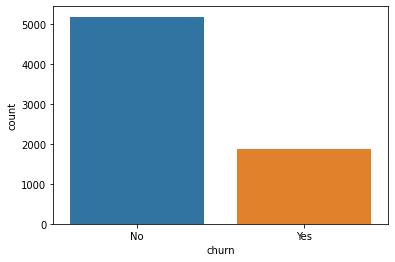

In [11]:
sns.countplot(data=df,x='churn')

## Checking to see all features have a significant count

In [33]:
categorical_variables = []
for x in df.select_dtypes(exclude = 'number').columns:
    categorical_variables.append(x)
    

categorical_variables.append('senior_citizen')
categorical_variables

['gender',
 'partner',
 'dependents',
 'phone_service',
 'multiple_lines',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'contract',
 'paperless_billing',
 'payment_method',
 'churn',
 'senior_citizen']

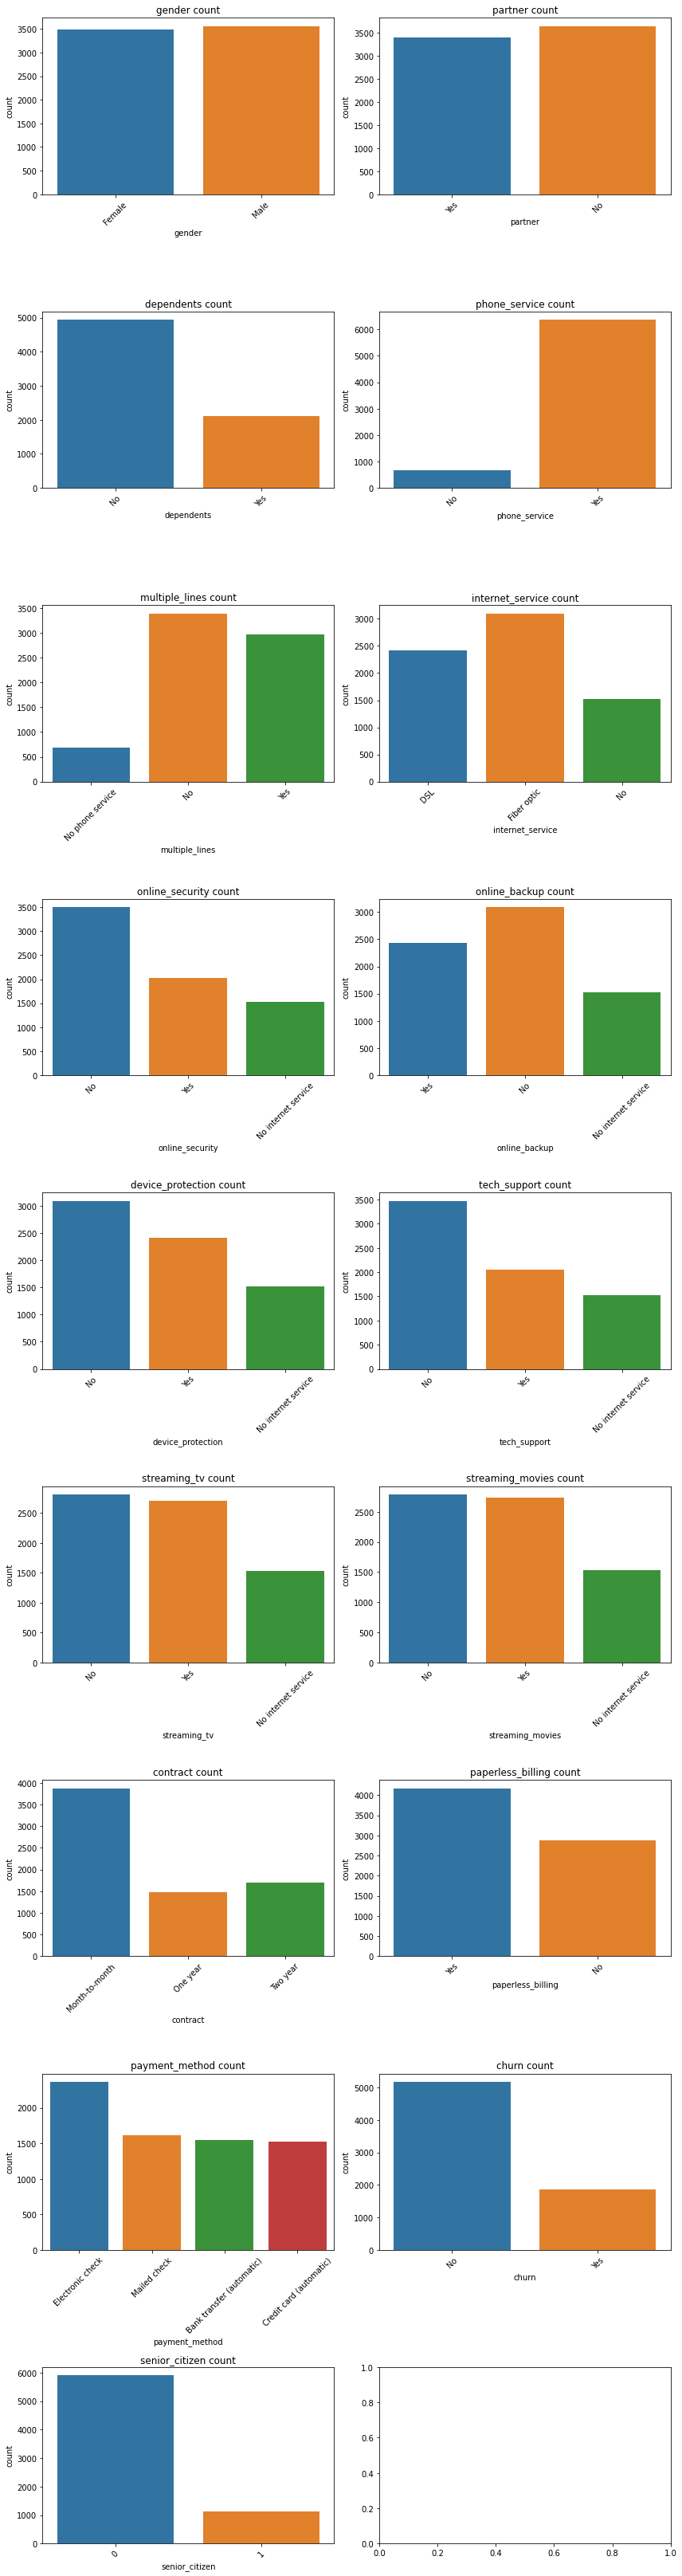

In [18]:
# row = 24 // 2 = 12 ... columns = 2 
n_rows, n_cols = (len(categorical_variables)+1)//2, 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*6, n_rows*5))
#fig.suptitle('Count Plots', fontsize=26)

for r in range(n_rows):
    for c in range(n_cols):
        try:
            i = r*n_cols+c
            ax = axs[r][c]
            sns.countplot(data=df, x = categorical_variables[i], ax=ax)
            ax.set_title(categorical_variables[i]+' count', fontsize=12)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
            fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
        except:
            break

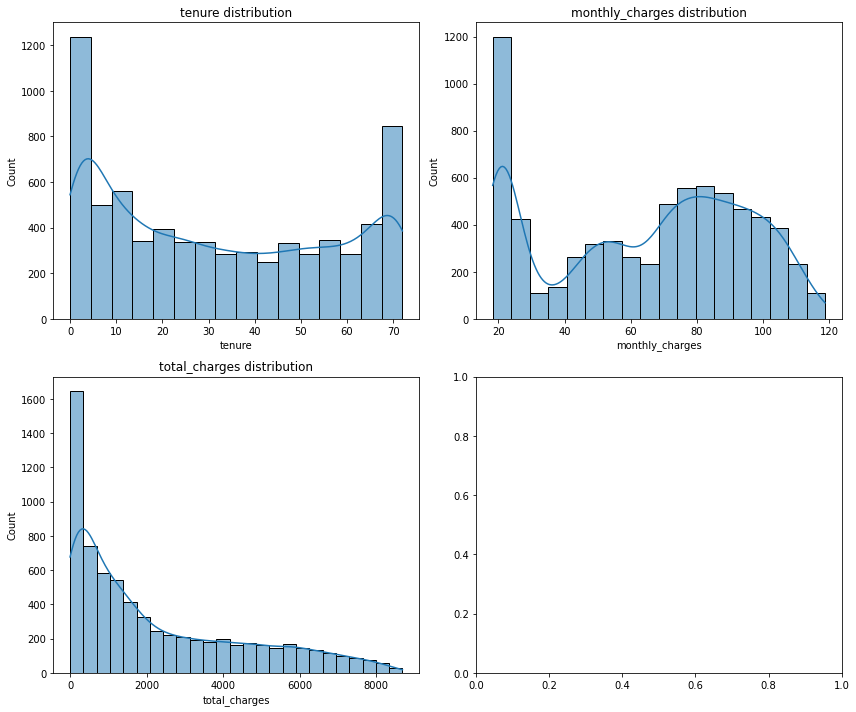

In [21]:
n_rows, n_cols = (len(numerical_features)+1)//2, 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*6, n_rows*5))
#fig.suptitle('Count Plots', fontsize=26)
for r in range(n_rows):
    for c in range(n_cols):
        try:
            i = r*n_cols+c
            ax = axs[r][c]
            sns.histplot(data=df, x = numerical_features[i], ax=ax,kde=True)
            ax.set_title(numerical_features[i]+' distribution', fontsize=12)
            #ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
            fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
        except:
            break

<AxesSubplot:xlabel='total_charges', ylabel='Count'>

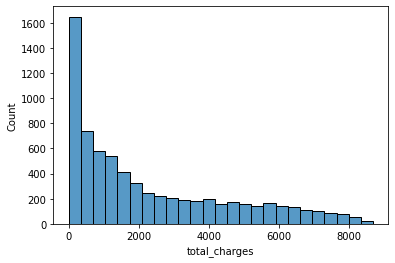

In [20]:
sns.histplot(data=df, x = 'total_charges')

# Bivariate analysis 

In [ ]:
df1 = 

<AxesSubplot:>

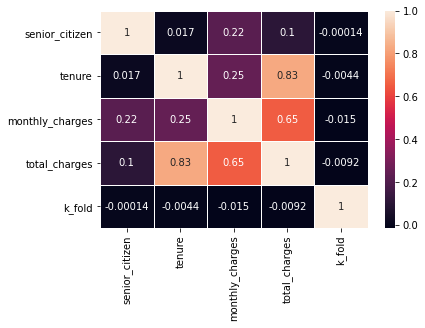

In [39]:
sns.heatmap(df.corr(),linewidths=1, linecolor='white',annot=True)

In [7]:
df2 = dataset.sorted_categorical_features_df(
                                    dataframe = df,
                                    binary_features = dispatcher.features['binary_features'],
                                    ordinal_features = None,
                                    ordinal_features_order = 'auto',
                                    numerical_features = dispatcher.features['numerical_features'],
                                    nominal_features = dispatcher.features['nominal_features'],
                                    drop_nominal_level = None,
                                    target_feature=dispatcher.features['target_feature'],
                                    fold_feature = dispatcher.features['fold_feature']
                                   )
  #df = dataset_1.sorted_categorical_features_df(
  #                                              dataframe = df,
  #                                              binary_features = binary_features,
  #                                              ordinal_features = ordinal_features,
  ##                                              ordinal_features_order = ordinal_features_order,
   #                                             numerical_features = numerical_features,
   #                                             nominal_features = nominal_features,
   #                                             drop_nominal_level = drop_nominal_level,
    #                                            target_feature=target_feature,
    #                                            fold_feature = fold_feature
    #                                            )#

In [27]:
df3 = df2.copy()

In [28]:
# I already know about the same feature multiple times
#x1_No is the same feature
internet_service_features = ['x7_No internet service',
                            'x6_No internet service',
                            'x5_No internet service',
                            'x4_No internet service',
                            'x3_No internet service',
                            'x2_No internet service'
                                  ]
for _ in internet_service_features:
    df3 = df3.drop(_,axis=1)
df3 = df3.drop('x0_No phone service',axis=1)

In [29]:
df3.shape

(7043, 35)

In [8]:
df2.shape

(7043, 42)

In [9]:
df2.shape

(7043, 42)

In [10]:
df2.head(4)

,gender,senior_citizen,partner,dependents,phone_service,paperless_billing,tenure,monthly_charges,total_charges,x0_No,x0_No phone service,x0_Yes,x1_DSL,x1_Fiber optic,x1_No,x2_No,x2_No internet service,x2_Yes,x3_No,x3_No internet service,x3_Yes,x4_No,x4_No internet service,x4_Yes,x5_No,x5_No internet service,x5_Yes,x6_No,x6_No internet service,x6_Yes,x7_No,x7_No internet service,x7_Yes,x8_Month-to-month,x8_One year,x8_Two year,x9_Bank transfer (automatic),x9_Credit card (automatic),x9_Electronic check,x9_Mailed check,churn,k_fold
0,0,0,1,0,0,1,1,29.85,29.85,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1
1,1,0,0,0,1,0,34,56.95,1889.50,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1
2,1,0,0,0,1,1,2,53.85,108.15,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,1,1
3,1,0,0,0,0,0,45,42.30,1840.75,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1


In [16]:
df.head(2)

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn,k_fold
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,1
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,1


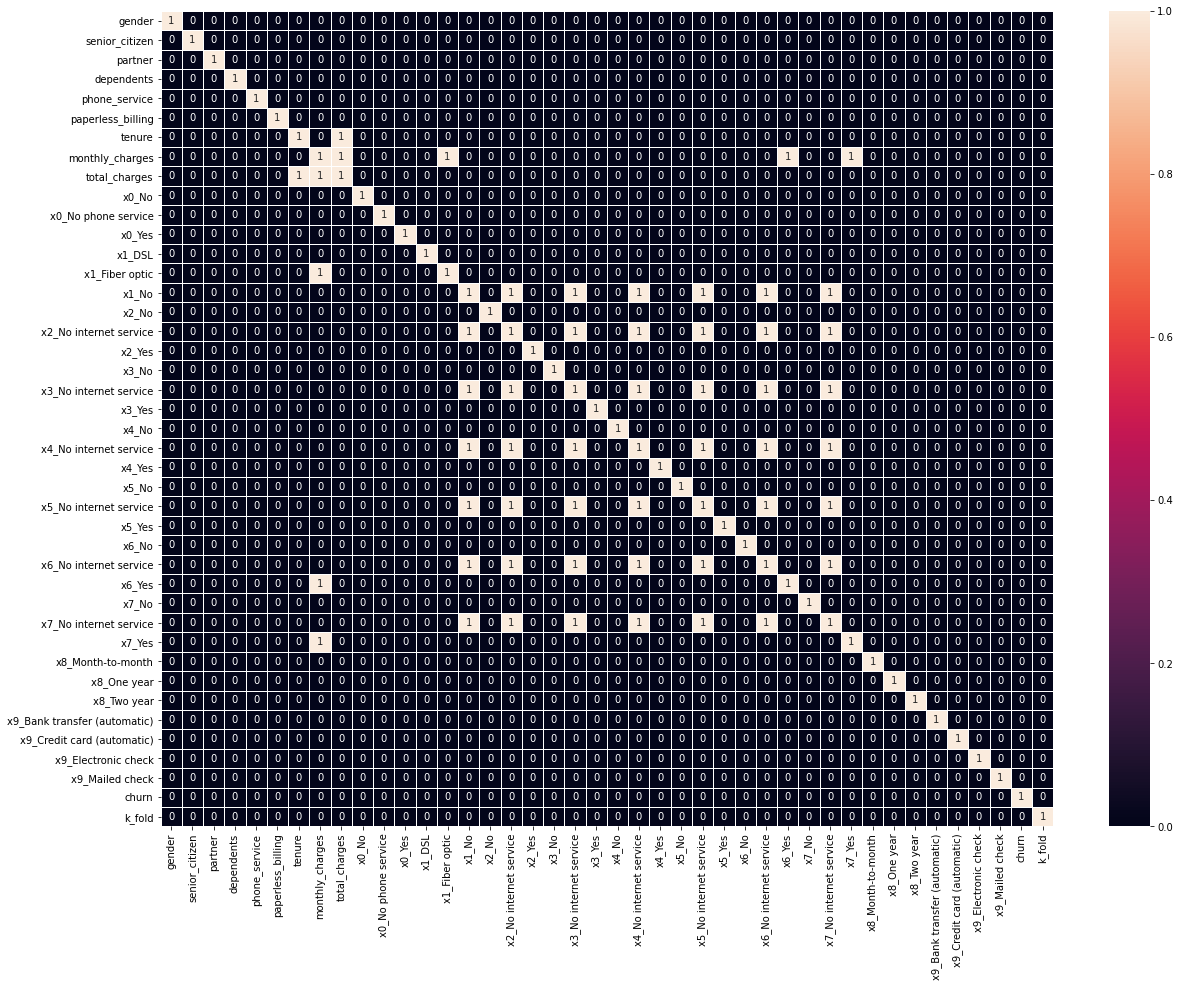

In [14]:
plt.figure(figsize=(20, 15))
sns.heatmap(abs(df2.corr(method='spearman')>0.6),linewidths=1, linecolor='white',annot=True)
plt.show()

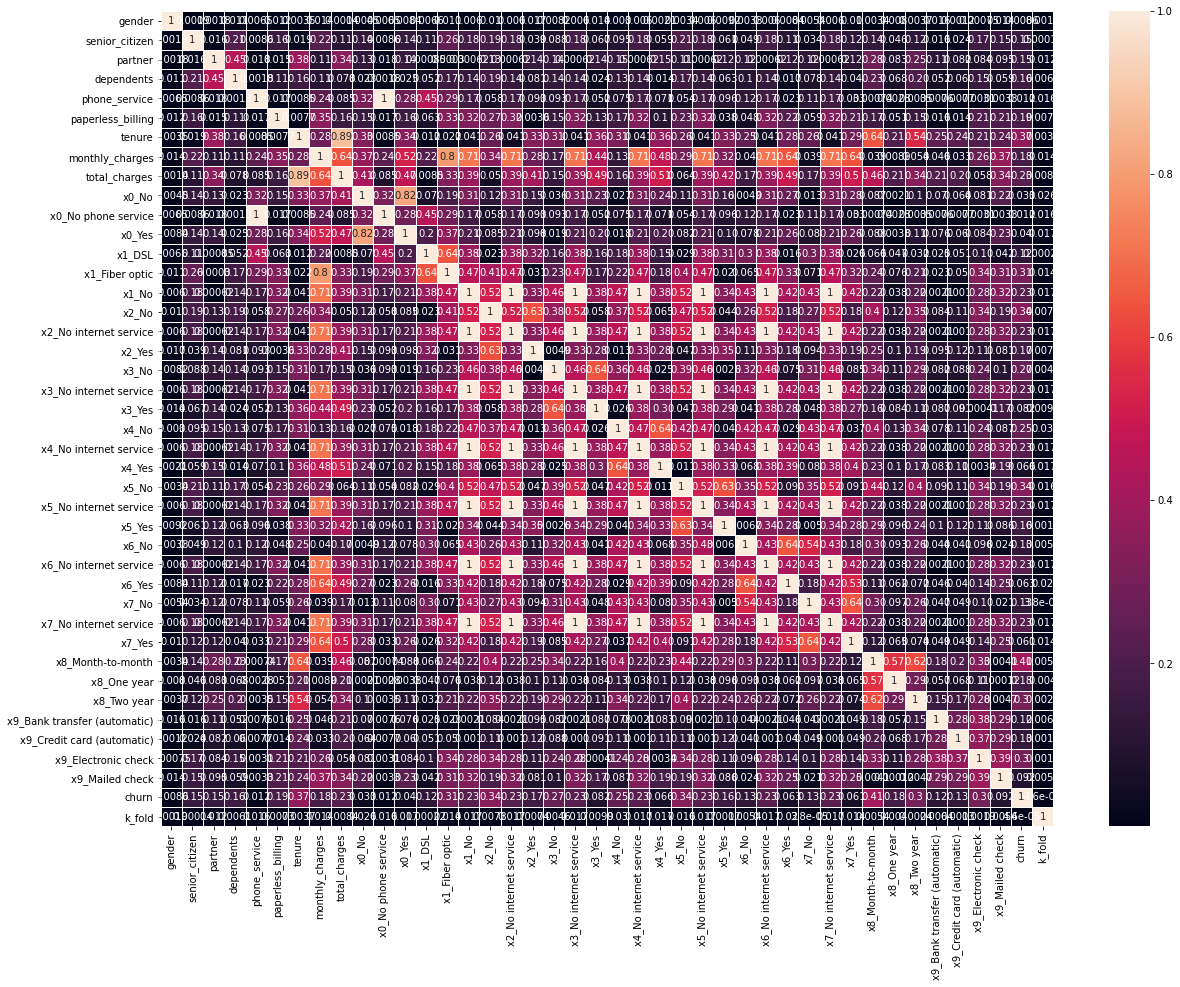

In [15]:
plt.figure(figsize=(20, 15))
sns.heatmap(abs(df2.corr(method='spearman')),linewidths=1, linecolor='white',annot=True)
plt.show()

In [18]:
df2.columns

Index(['gender', 'senior_citizen', 'partner', 'dependents', 'phone_service',
       'paperless_billing', 'tenure', 'monthly_charges', 'total_charges',
       'x0_No', 'x0_No phone service', 'x0_Yes', 'x1_DSL', 'x1_Fiber optic',
       'x1_No', 'x2_No', 'x2_No internet service', 'x2_Yes', 'x3_No',
       'x3_No internet service', 'x3_Yes', 'x4_No', 'x4_No internet service',
       'x4_Yes', 'x5_No', 'x5_No internet service', 'x5_Yes', 'x6_No',
       'x6_No internet service', 'x6_Yes', 'x7_No', 'x7_No internet service',
       'x7_Yes', 'x8_Month-to-month', 'x8_One year', 'x8_Two year',
       'x9_Bank transfer (automatic)', 'x9_Credit card (automatic)',
       'x9_Electronic check', 'x9_Mailed check', 'churn', 'k_fold'],
      dtype='object')

In [12]:
df2.corr(method='spearman')['churn']

gender                         -0.008612
senior_citizen                  0.150889
partner                        -0.150448
dependents                     -0.164221
phone_service                   0.011942
paperless_billing               0.191825
tenure                         -0.367062
monthly_charges                 0.184743
total_charges                  -0.229955
x0_No                          -0.032569
x0_No phone service            -0.011942
x0_Yes                          0.040102
x1_DSL                         -0.124214
x1_Fiber optic                  0.308020
x1_No                          -0.227890
x2_No                           0.342637
x2_No internet service         -0.227890
x2_Yes                         -0.171226
x3_No                           0.268005
x3_No internet service         -0.227890
x3_Yes                         -0.082255
x4_No                           0.252481
x4_No internet service         -0.227890
x4_Yes                         -0.066160
x5_No           

In [19]:
df.columns

Index(['gender', 'senior_citizen', 'partner', 'dependents', 'tenure',
       'phone_service', 'multiple_lines', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'contract', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'churn',
       'k_fold'],
      dtype='object')

In [29]:
df.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn,k_fold
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,1
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,1
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,1
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,2


In [31]:
df.phone_service.unique()

array(['No', 'Yes'], dtype=object)

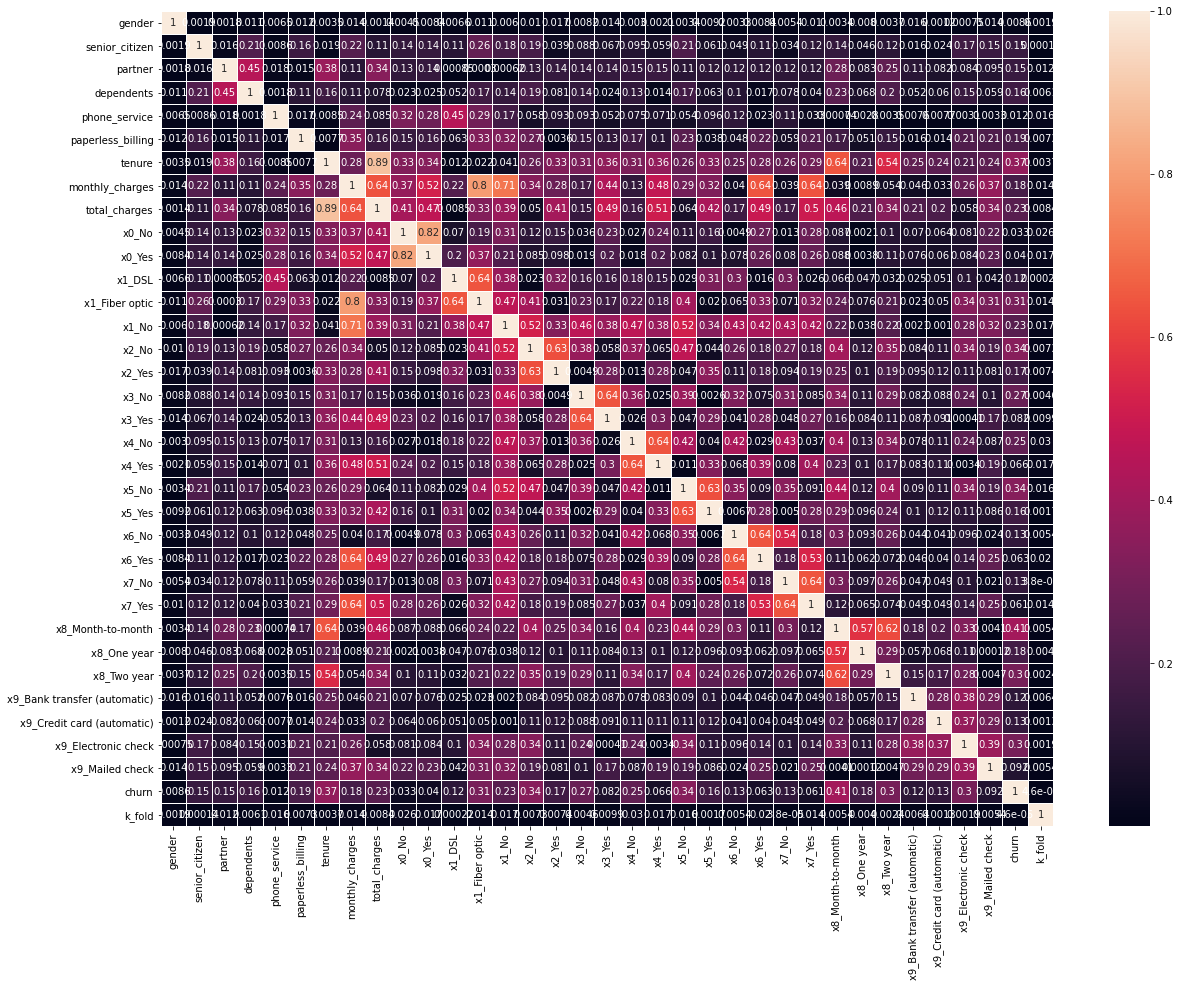

In [30]:
plt.figure(figsize=(20, 15))
sns.heatmap(abs(df3.corr(method='spearman')),linewidths=1, linecolor='white',annot=True)
plt.show()

In [25]:
df3.head(10)

,gender,senior_citizen,partner,dependents,phone_service,paperless_billing,tenure,monthly_charges,total_charges,x0_No,x0_No phone service,x0_Yes,x1_DSL,x1_Fiber optic,x1_No,x2_No,x2_Yes,x3_No,x3_Yes,x4_No,x4_Yes,x5_No,x5_Yes,x6_No,x6_Yes,x7_No,x7_Yes,x8_Month-to-month,x8_One year,x8_Two year,x9_Bank transfer (automatic),x9_Credit card (automatic),x9_Electronic check,x9_Mailed check,churn,k_fold
0,0,0,1,0,0,1,1,29.85,29.85,0,1,0,1,0,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,1
1,1,0,0,0,1,0,34,56.95,1889.50,1,0,0,1,0,0,0,1,1,0,0,1,1,0,1,0,1,0,0,1,0,0,0,0,1,0,1
2,1,0,0,0,1,1,2,53.85,108.15,1,0,0,1,0,0,0,1,0,1,1,0,1,0,1,0,1,0,1,0,0,0,0,0,1,1,1
3,1,0,0,0,0,0,45,42.30,1840.75,0,1,0,1,0,0,0,1,1,0,0,1,0,1,1,0,1,0,0,1,0,1,0,0,0,0,1
4,0,0,0,0,1,1,2,70.70,151.65,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,1,2
5,0,0,0,0,1,1,8,99.65,820.50,0,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,0,1,1,0,0,0,0,1,0,1,2
6,1,0,0,1,1,1,22,89.10,1949.40,0,0,1,0,1,0,1,0,0,1,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,0,4
7,0,0,0,0,0,0,10,29.75,301.90,0,1,0,1,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,1,0,4
8,0,0,1,0,1,1,28,104.80,3046.05,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,1,0,0,0,0,1,0,1,1
9,1,0,0,1,1,0,62,56.15,3487.95,1,0,0,1,0,0,0,1,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1
